While models run in the other notebook, analyze these ones here.

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d

import Week7_PFNutils as W

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

2021-08-11 07:57:53.647312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 07:58:01.898289: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-11 07:58:01.909827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-11 07:58:01.991081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-11 07:58:01.991122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 07:58:02.008154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
import vector as v

v.register_awkward()

In [3]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [20]:
model1 = tf.keras.models.load_model(data_path+'W15_rho3class.hdf5')

In [21]:
file = np.load(data_path+'nn_3classrho.npz')

In [22]:
X_test = file['arr_2']
Y_test = file['arr_5']
eta_test = file['arr_8']

In [32]:
max(eta_test)

2.999429941177368

In [43]:
eta_ranges1 = np.arange(0., 3.1, .5)

selec1 = abs(eta_test) < .5
selec2 = (abs(eta_test) >= .5) & (abs(eta_test) < 1.)
selec3 = (abs(eta_test) >= 1.) & (abs(eta_test) < 1.5)
selec4 = (abs(eta_test) >= 1.5) & (abs(eta_test) < 2.)
selec5 = (abs(eta_test) >= 2.) & (abs(eta_test) < 2.5)
selec6 = (abs(eta_test) >= 2.5) & (abs(eta_test) <= 3.)
selec_all = abs(eta_test) <= 3. 

eta_sel1 = [selec1, selec2, selec3, selec4, selec5, selec6, selec_all]

In [25]:
fps1, tps1, aucs1, preds1 = W.metrics_ng(model1, X_test, Y_test, eta_sel1)

PFN AUC: 0.9593863765658719
PFN AUC: 0.9530543380361505
PFN AUC: 0.9223243411297651
PFN AUC: 0.9170558768176139
PFN AUC: 0.9308540370678761
PFN AUC: 0.9433960573126267


2021-08-11 08:27:16.300033: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3456000000 exceeds 10% of free system memory.


PFN AUC: 0.9377841764992016


In [27]:
score1, score2, score3 = [], [], []
for i in range(len(preds1)):
    score1.append(preds1[i].T[0])
    score2.append(preds1[i].T[1])
    score3.append(preds1[i].T[2])

In [76]:
len(score1[2])

22353

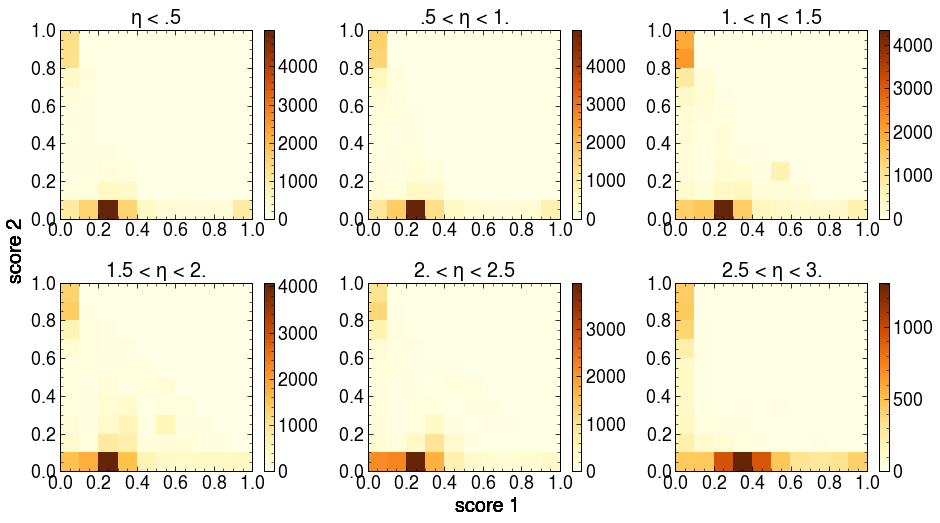

In [77]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[14,8])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
tics = [0., .2, .4, .6, .8, 1.0]
labs = ['$\eta$ < .5', '.5 < $\eta$ < 1.', '1. < $\eta$ < 1.5', '1.5 < $\eta$ < 2.', '2. < $\eta$ < 2.5', '2.5 < $\eta$ < 3.']
for i in range(len(axes)):
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlim(0., 1.)
    h = axes[i].hist2d(score1[i], score2[i], cmap='YlOrBr')
    axes[i].set_xticks(tics)
    axes[i].set_yticks(tics)
    axes[i].set_title(labs[i])
    plt.tight_layout()
    fig.colorbar(h[-1], ax=axes[i])
    #add big axis just for x/y labels
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("score 1")
    plt.ylabel("score 2")
    

Now have to try to separate the true __ cases in order to understand what this plot means:

In [64]:
Y_test[0] #I think it should mean that in the 0th position, that's pi0, in the 1st position = pipm, and in the
        #2nd position that's overlapping. 

array([0., 1., 0.], dtype=float32)

In [29]:
true1, true2, true3 = Y_test.T #so true1 = pi0, true2 = pipm, true3 = overlap

In [62]:
true1

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [30]:
pi0masks = []
pipmmasks = []
lapmasks = []
for sel in eta_sel1:
    pi0masks.append(true1[sel] == 1)
    pipmmasks.append(true2[sel] == 1)
    lapmasks.append(true3[sel] == 1)

In [31]:
truepi0 = true1 == 1
truepipm = true2 == 1
truelap = true3 == 1

In [70]:
truelap

array([False, False, False, ..., False, False, False])

In [78]:
sc1, sc2, sc3 = preds[-1].T

In [80]:
len(sc1), len(truepi0), len(sc2), len(truepipm)

(108000, 108000, 108000, 108000)

In [81]:
len(sc1[truepi0]), len(sc2[truepipm]), len(sc3[truelap])

(27236, 26812, 53952)

(array([[ 254.,   22.,   19.,   13.,   16.,   14.,   37.,   91.,  188.,
           85.],
        [1674.,  116.,   48.,   51.,   49.,   64.,   90.,  100.,   27.,
            0.],
        [5695.,  722.,  301.,  213.,  142.,   48.,   65.,   16.,    0.,
            0.],
        [2939.,  962.,  498.,  164.,   31.,   60.,   32.,    0.,    0.,
            0.],
        [1592.,  259.,   99.,   36.,  103.,   77.,    0.,    0.,    0.,
            0.],
        [1111.,  211.,  702.,  101.,  141.,    0.,    0.,    0.,    0.,
            0.],
        [1053.,  223.,   82.,  107.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [1208.,   96.,   80.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [1517.,   73.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [3519.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]]),
 array([1.40807481e-06, 1.00001255e-01, 2.00001103e-01, 3.00000950e-01,
        4.00000797e-01, 5.00000644e-

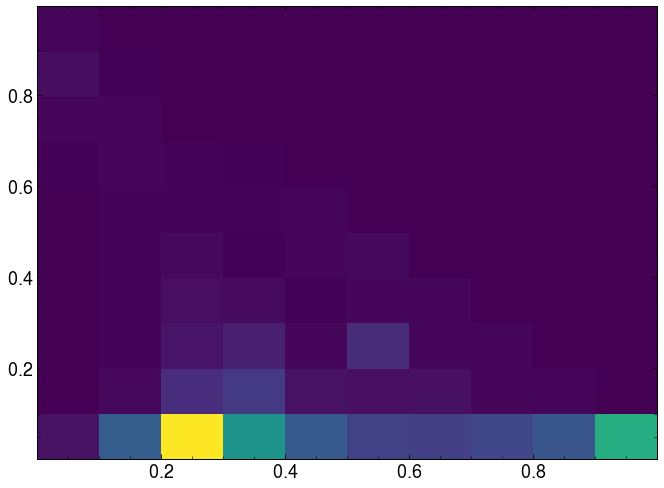

In [84]:
plt.hist2d(sc1[truepi0], sc2[truepi0])

In [4]:
def Score2D(score1, score2, true=None):
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[14,8])
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    tics = [0., .2, .4, .6, .8, 1.0]
    labs = ['$\eta$ < .5', '.5 < $\eta$ < 1.', '1. < $\eta$ < 1.5', '1.5 < $\eta$ < 2.', '2. < $\eta$ < 2.5', '2.5 < $\eta$ < 3.']
    for i in range(len(axes)):
        axes[i].set_ylim(0., 1.)
        axes[i].set_xlim(0., 1.)
        if true is not None:
            h = axes[i].hist2d(score1[i][true[i]], score2[i][true[i]], cmap='YlOrBr')
        else:
            h = axes[i].hist2d(score1[i], score2[i], cmap='YlOrBr')
        axes[i].set_xticks(tics)
        axes[i].set_yticks(tics)
        axes[i].set_title(labs[i])
        plt.tight_layout()
        fig.colorbar(h[-1], ax=axes[i])
        #add big axis just for x/y labels
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        plt.xlabel("score 1")
        plt.ylabel("score 2")


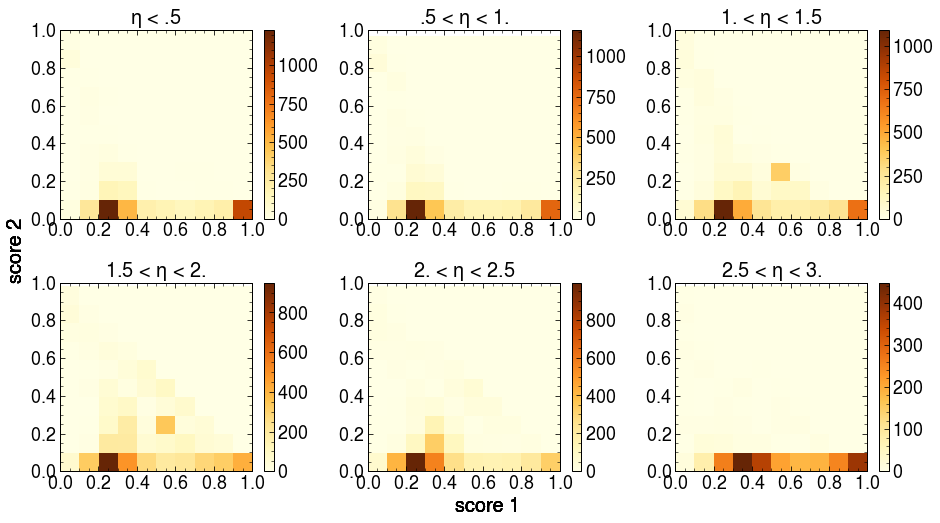

In [93]:
Score2D(score1, score2, pi0masks)

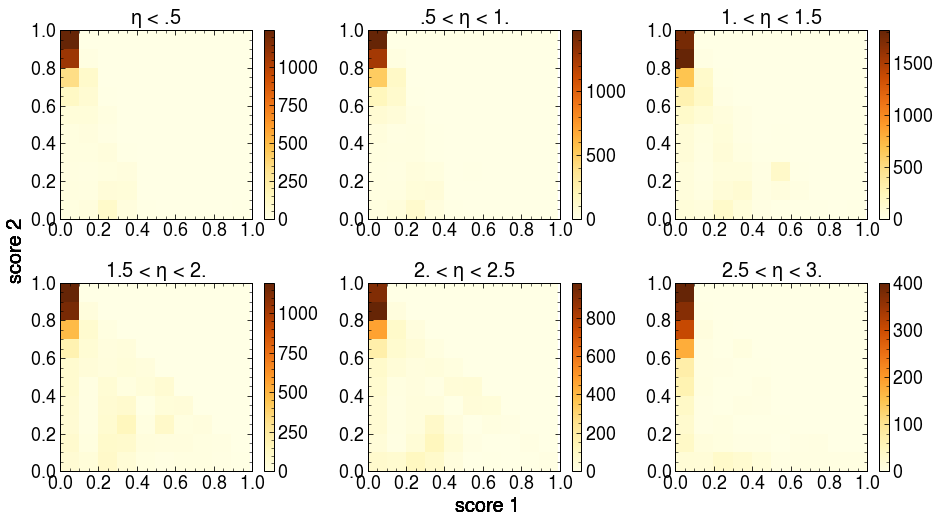

In [94]:
Score2D(score1, score2, pipmmasks)

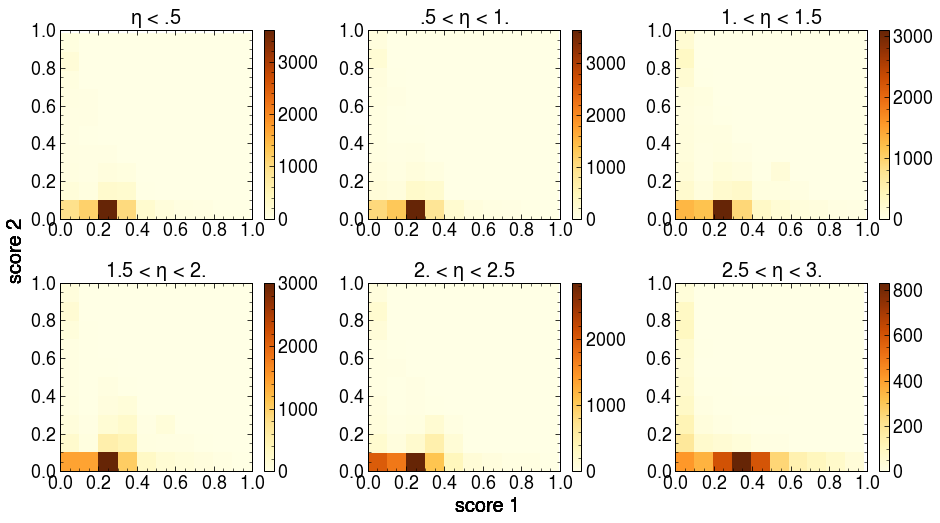

In [95]:
Score2D(score1, score2, lapmasks)

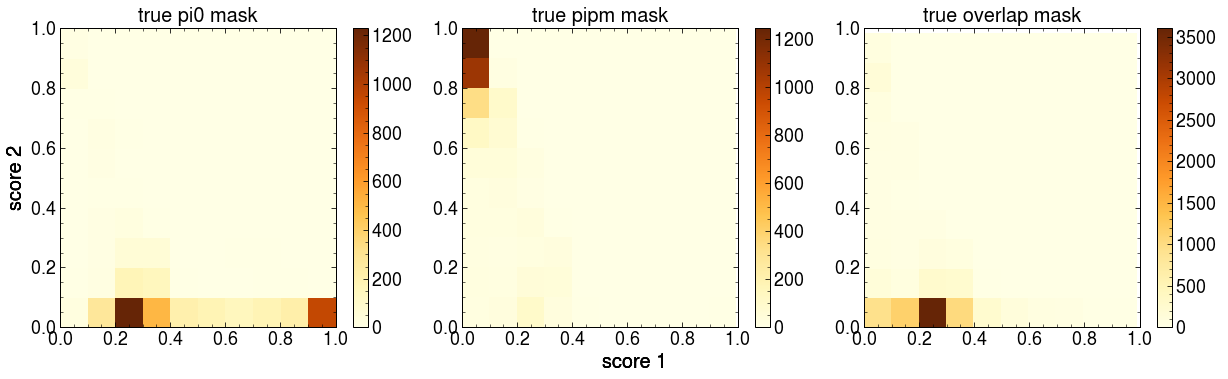

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=[18,6])
axes = [ax1, ax2, ax3]
tics = [0., .2, .4, .6, .8, 1.0]
labs = ['true pi0 mask', 'true pipm mask', 'true overlap mask']
truths = [pi0masks[0], pipmmasks[0], lapmasks[0]]
for i in range(len(axes)):
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlim(0., 1.)
    h = axes[i].hist2d(score1[0][truths[i]], score2[0][truths[i]], cmap='YlOrBr')
    axes[i].set_xticks(tics)
    axes[i].set_yticks(tics)
    axes[i].set_title(labs[i])
    plt.tight_layout()
    fig.colorbar(h[-1], ax=axes[i])
    #add big axis just for x/y labels
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("score 1")
    plt.ylabel("score 2")

In [5]:
def focus_Score2D(score1, score2, truths):
    #give it a specific eta range of score1&2 (or all of them) and the corresponding truths****
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=[18,6])
    axes = [ax1, ax2, ax3]
    tics = [0., .2, .4, .6, .8, 1.0]
    labs = ['true pi0 mask', 'true pipm mask', 'true overlap mask']
    for i in range(len(axes)):
        axes[i].set_ylim(0., 1.)
        axes[i].set_xlim(0., 1.)
        h = axes[i].hist2d(score1[truths[i]], score2[truths[i]], cmap='YlOrBr')
        axes[i].set_xticks(tics)
        axes[i].set_yticks(tics)
        axes[i].set_title(labs[i])
        plt.tight_layout()
        fig.colorbar(h[-1], ax=axes[i])
        #add big axis just for x/y labels
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        plt.xlabel("score 1")
        plt.ylabel("score 2")

In [32]:
#cool!!! so now let's try the second model. Wonder if it'll be different at all?

model2 = tf.keras.models.load_model(data_path+'W15_rho3class_larger.hdf5')
file2 = np.load(data_path+'nn_3classrho_larger.npz')

In [33]:
X_test_larger = file2['arr_2']
Y_test_larger = file2['arr_5']
eta_test_larger = file2['arr_8']

In [55]:
pt_test_larger = file2['arr_14']

In [34]:
selec1 = abs(eta_test_larger) < .5
selec2 = (abs(eta_test_larger) >= .5) & (abs(eta_test_larger) < 1.)
selec3 = (abs(eta_test_larger) >= 1.) & (abs(eta_test_larger) < 1.5)
selec4 = (abs(eta_test_larger) >= 1.5) & (abs(eta_test_larger) < 2.)
selec5 = (abs(eta_test_larger) >= 2.) & (abs(eta_test_larger) < 2.5)
selec6 = (abs(eta_test_larger) >= 2.5) & (abs(eta_test_larger) <= 3.)
selec_all = abs(eta_test_larger) <= 3. 

eta_selL = [selec1, selec2, selec3, selec4, selec5, selec6, selec_all]

In [35]:
fpsL, tpsL, aucsL, predsL = W.metrics_ng(model2, X_test_larger, Y_test_larger, eta_selL)

PFN AUC: 0.9669219538764761
PFN AUC: 0.9609384835595454
PFN AUC: 0.9335125633604782
PFN AUC: 0.9263812481195686
PFN AUC: 0.9351780210923513
PFN AUC: 0.9525215681516699


2021-08-11 08:43:13.638167: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2624000000 exceeds 10% of free system memory.


PFN AUC: 0.9460926277611736


In [36]:
score1LG, score2LG, score3LG = [], [], []
for i in range(len(predsL)):
    score1LG.append(predsL[i].T[0])
    score2LG.append(predsL[i].T[1])
    score3LG.append(predsL[i].T[2])

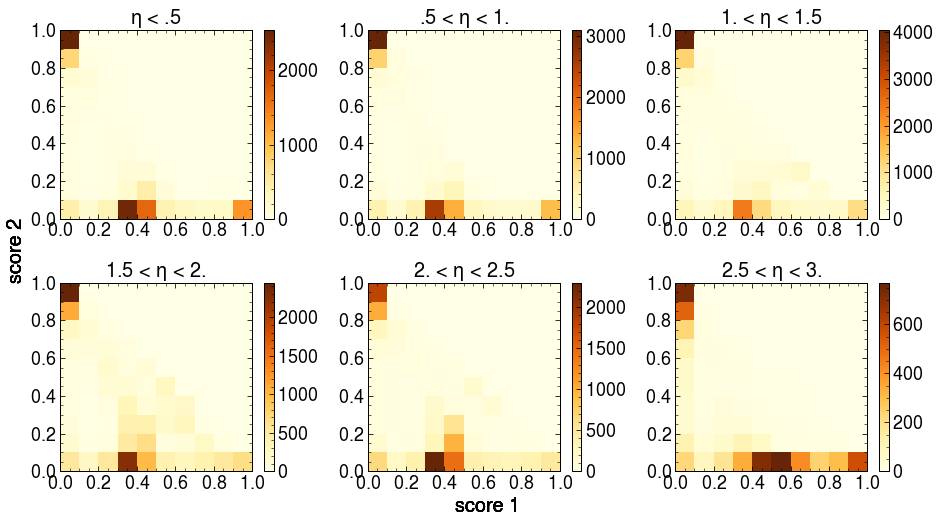

In [105]:
#no selection:
Score2D(score1LG, score2LG)

In [37]:
true1LG, true2LG, true3LG = Y_test_larger.T #so true1 = pi0, true2 = pipm, true3 = overlap

pi0masksLG = []
pipmmasksLG = []
lapmasksLG = []
for sel in eta_selL:
    pi0masksLG.append(true1LG[sel] == 1)
    pipmmasksLG.append(true2LG[sel] == 1)
    lapmasksLG.append(true3LG[sel] == 1)

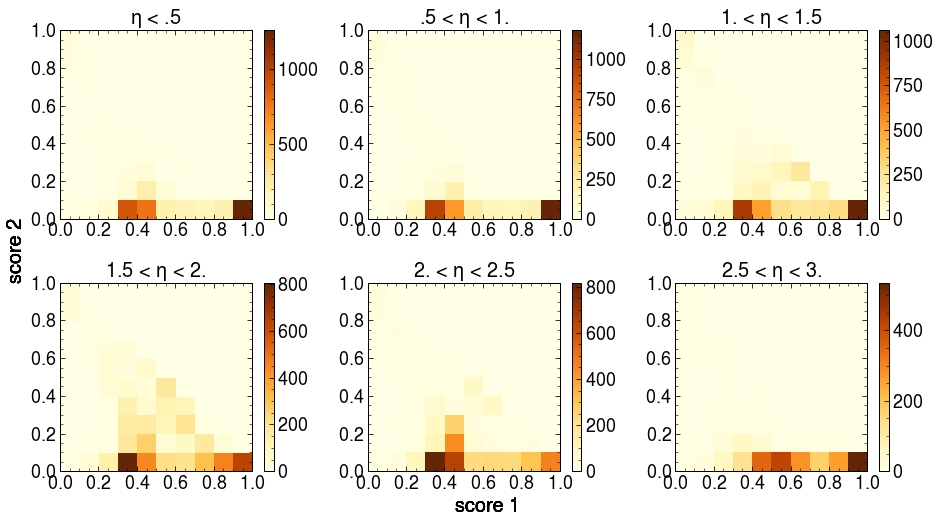

In [107]:
Score2D(score1LG, score2LG, pi0masksLG)

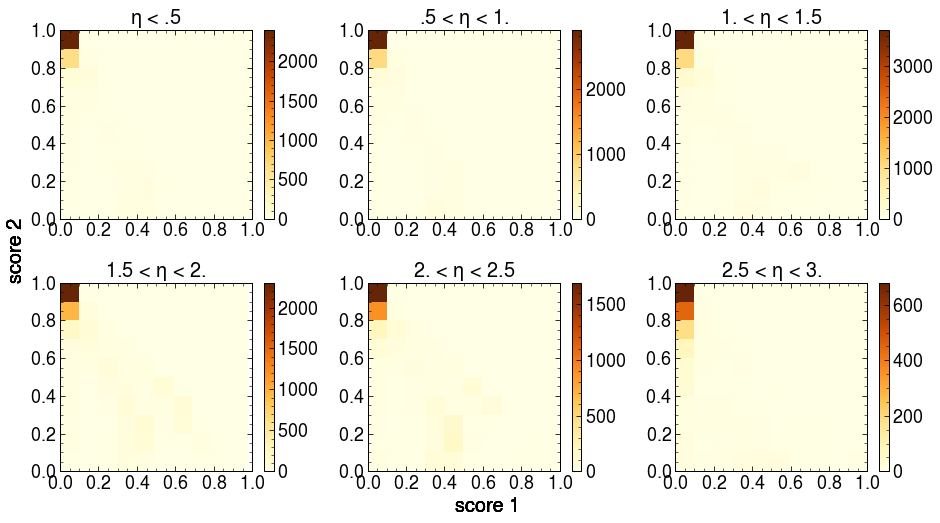

In [108]:
Score2D(score1LG, score2LG, pipmmasksLG)

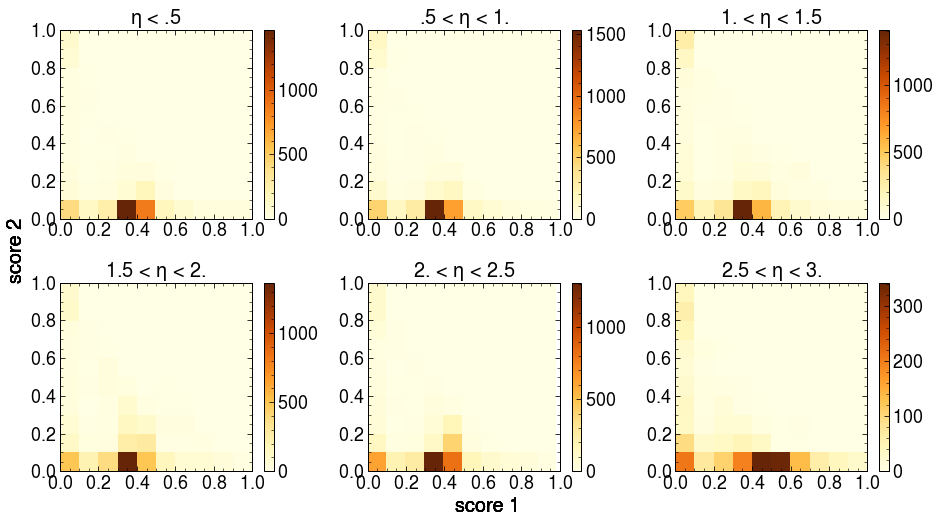

In [109]:
Score2D(score1LG, score2LG, lapmasksLG)

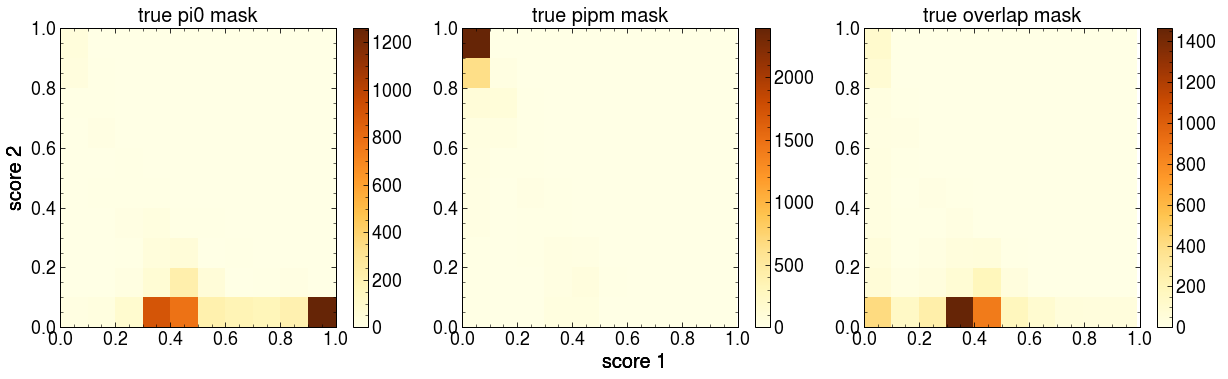

In [110]:
focus_Score2D(score1LG[0], score2LG[0], truths=[pi0masksLG[0], pipmmasksLG[0], lapmasksLG[0]])

In [9]:
#and for the global eta model:

modelg = tf.keras.models.load_model(model_path+'W15_3classGlobal.hdf5')
fileg = np.load(data_path+'nn_3classrho_larger.npz') #since it uses this same set of data

In [10]:
fpsG, tpsG, aucsG, predsG = W.metrics(modelg, X_test_larger, eta_test_larger, Y_test_larger, eta_selL)

2021-08-11 08:00:06.878322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-11 08:00:06.899802: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-08-11 08:00:07.012488: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-11 08:00:10.093772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


PFN AUC: 0.9680440178115192
PFN AUC: 0.960791497652102
PFN AUC: 0.9357702950409296
PFN AUC: 0.9260820550390769
PFN AUC: 0.9359168715912681
PFN AUC: 0.9506521588490616


2021-08-11 08:03:31.211544: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2624000000 exceeds 10% of free system memory.


PFN AUC: 0.9466579516578058


In [11]:
len(predsG)

7

In [12]:
score1G, score2G, score3G = [], [], []
for i in range(len(predsG)):
    score1G.append(predsG[i].T[0])
    score2G.append(predsG[i].T[1])
    score3G.append(predsG[i].T[2])

In [13]:
len(score1G),len(score2G)

(7, 7)

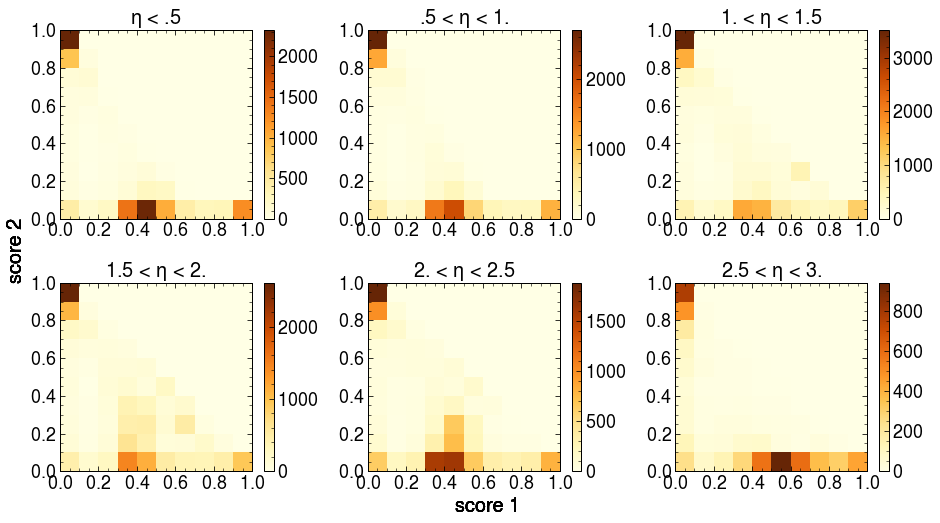

In [14]:
#no selection:
Score2D(score1G, score2G)

In [15]:
true1G, true2G, true3G = Y_test_larger.T #so true1 = pi0, true2 = pipm, true3 = overlap

pi0masksG = []
pipmmasksG = []
lapmasksG = []
for sel in eta_selL:
    pi0masksG.append(true1G[sel] == 1)
    pipmmasksG.append(true2G[sel] == 1)
    lapmasksG.append(true3G[sel] == 1)

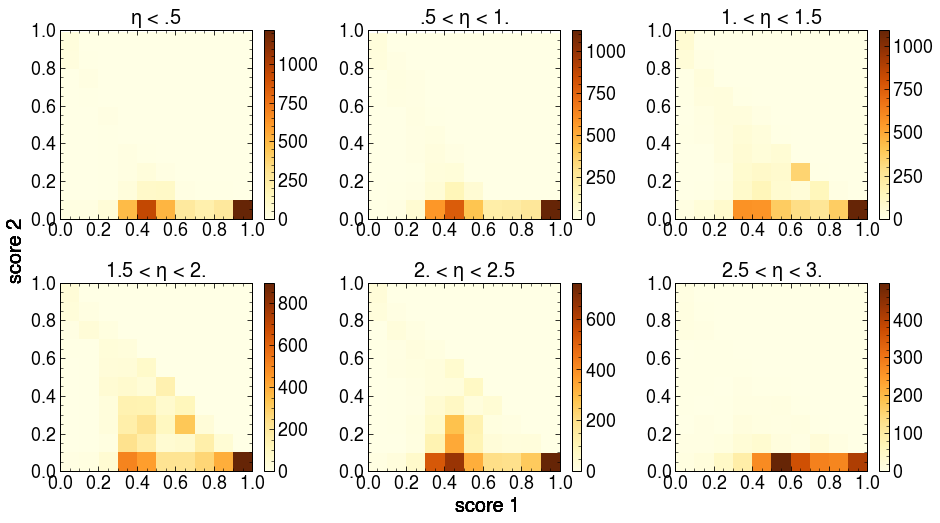

In [16]:
Score2D(score1G, score2G, pi0masksG)

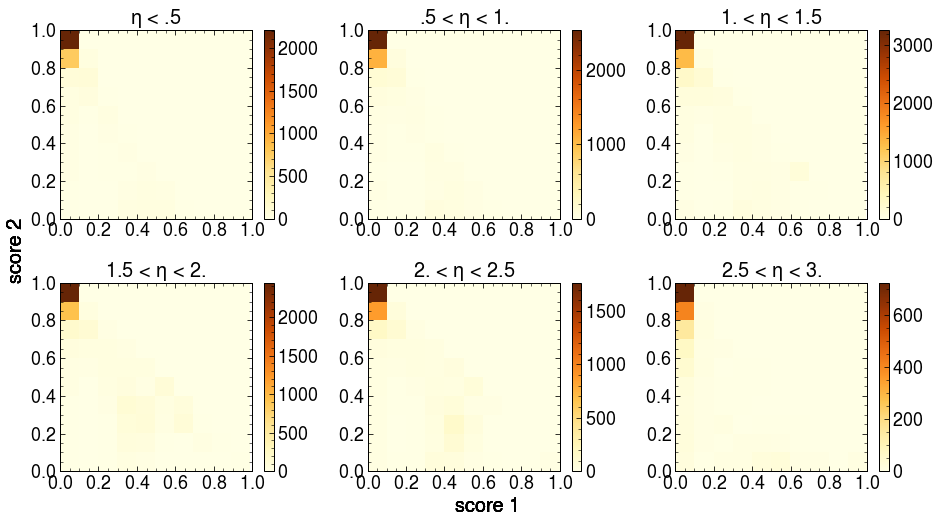

In [17]:
Score2D(score1G, score2G, pipmmasksG)

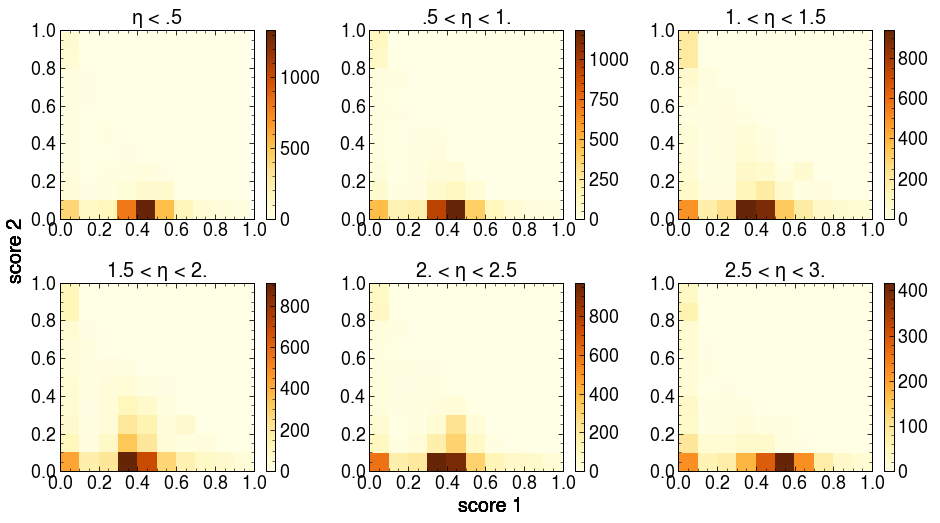

In [18]:
Score2D(score1G, score2G, lapmasksG)

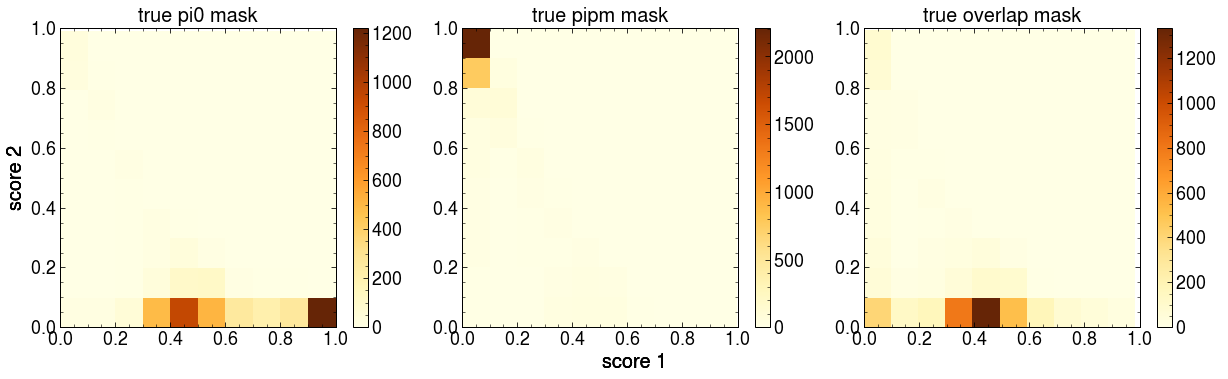

In [19]:
focus_Score2D(score1G[0], score2G[0], truths=[pi0masksG[0], pipmmasksG[0], lapmasksG[0]])

In [65]:
reg951 = W.interp95(fps1, tps1)
reg95L = W.interp95(fpsL, tpsL)
reg95G = W.interp95(fpsG, tpsG)
reg95G2 = W.interp95(fpsG2, tpsG2)

/home/kaelaekd/start_tf/LCStudies/classifier/Week7_PFNutils.py:84: RuntimeWarning: divide by zero encountered in true_divide
  fg.append(interp1d(tps[i], 1/fps[i]))


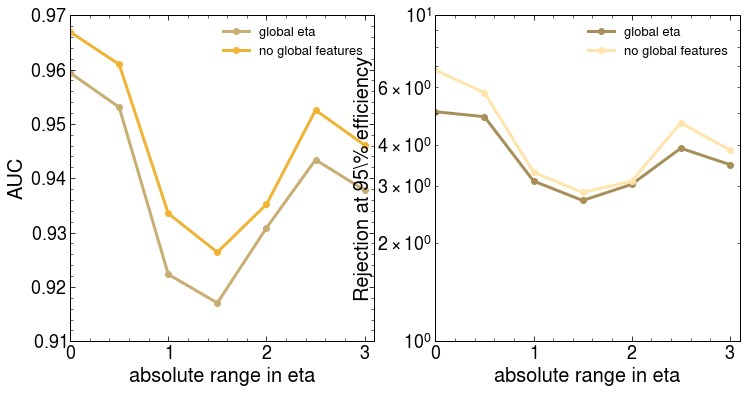

In [44]:
#just compare the small and large no glob first
W.plots1(eta_ranges1, aucs1, aucsL, reg951, reg95L, rangename='eta', globalpars='eta', logx=False)
#note that here glob = small and noglob = large, so make sense. the fixed dataset did better

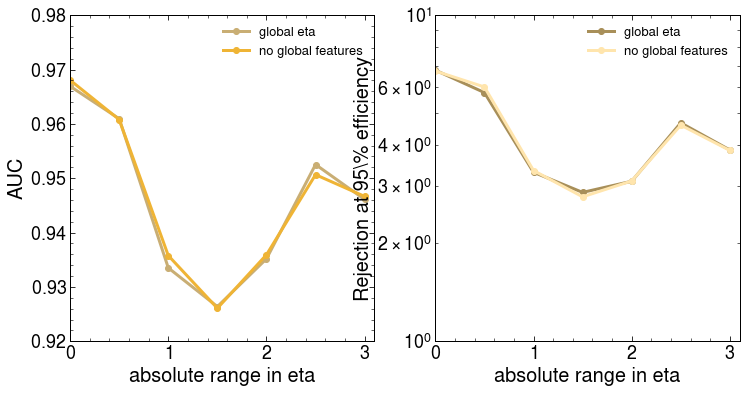

In [46]:
#then large no glob and glob!!
W.plots1(eta_ranges1, aucsL, aucsG, reg95L, reg95G, rangename='eta', globalpars='eta', logx=False)
#and here glob = glob, no glob is large. no discernable difference. 

In [53]:
#and for the global eta + pt model:

modelg2 = tf.keras.models.load_model(model_path+'W15_3classGlobaletaNpt.hdf5')
fileg2 = np.load(data_path+'nn_3classrho_larger.npz') #since it uses this same set of data

In [56]:
X_glob_test_1 = np.stack((np.array(eta_test_larger), np.array(pt_test_larger)), axis=1)

In [57]:
fpsG2, tpsG2, aucsG2, predsG2 = W.metrics(modelg2, X_test_larger, X_glob_test_1, Y_test_larger, eta_selL)

PFN AUC: 0.9666454317271895
PFN AUC: 0.96023723156266
PFN AUC: 0.9347282256845266
PFN AUC: 0.9251251000569019
PFN AUC: 0.9353074097988304
PFN AUC: 0.9528355210707935


2021-08-11 12:10:41.634646: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2624000000 exceeds 10% of free system memory.


PFN AUC: 0.9461323357226578


In [58]:
score1G2, score2G2, score3G2 = [], [], []
for i in range(len(predsG2)):
    score1G2.append(predsG2[i].T[0])
    score2G2.append(predsG2[i].T[1])
    score3G2.append(predsG2[i].T[2])

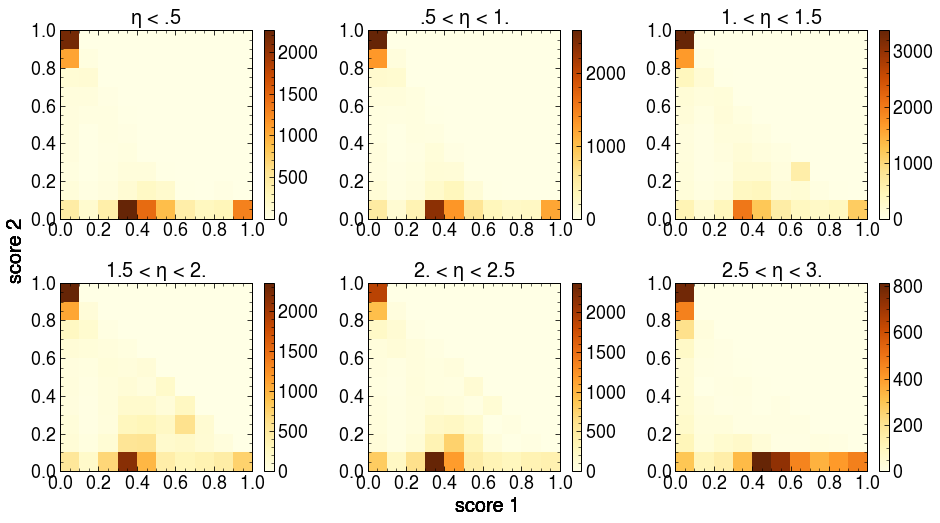

In [59]:
#no selection:
Score2D(score1G2, score2G2)

In [60]:
true1G2, true2G2, true3G2 = Y_test_larger.T #so true1 = pi0, true2 = pipm, true3 = overlap

pi0masksG2 = []
pipmmasksG2 = []
lapmasksG2 = []
for sel in eta_selL:
    pi0masksG2.append(true1G2[sel] == 1)
    pipmmasksG2.append(true2G2[sel] == 1)
    lapmasksG2.append(true3G2[sel] == 1)

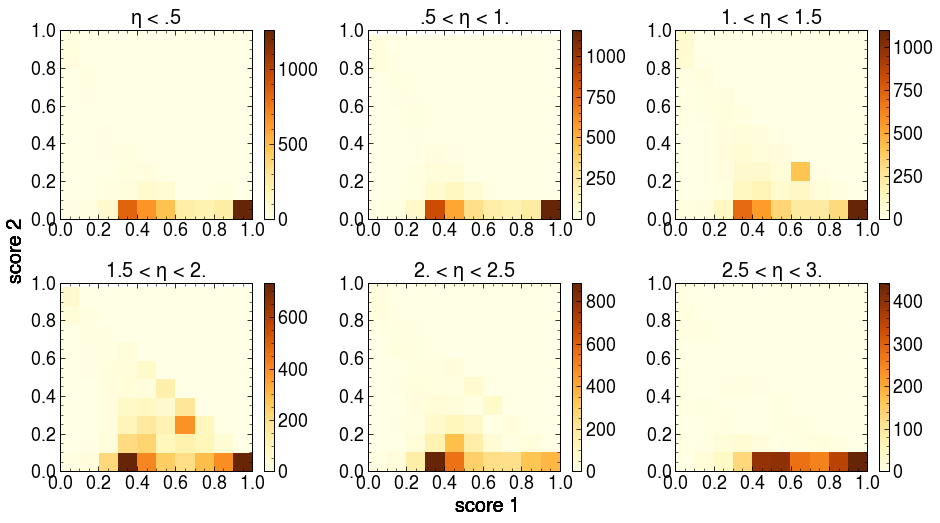

In [61]:
Score2D(score1G2, score2G2, pi0masksG2)

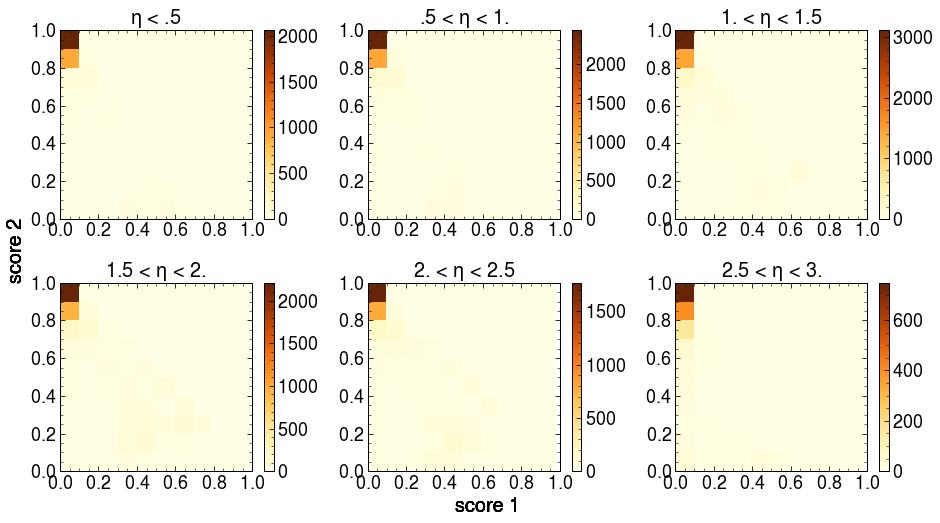

In [62]:
Score2D(score1G2, score2G2, pipmmasksG2)

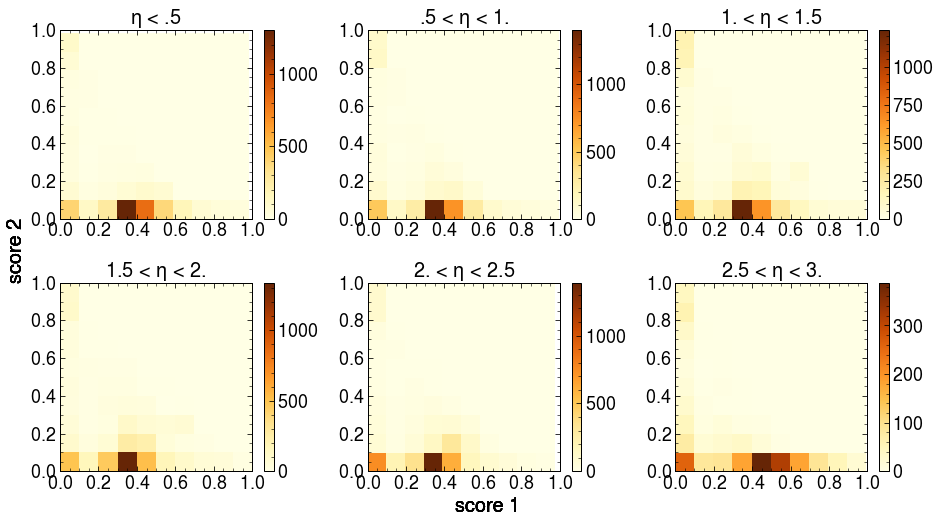

In [63]:
Score2D(score1G2, score2G2, lapmasksG2)

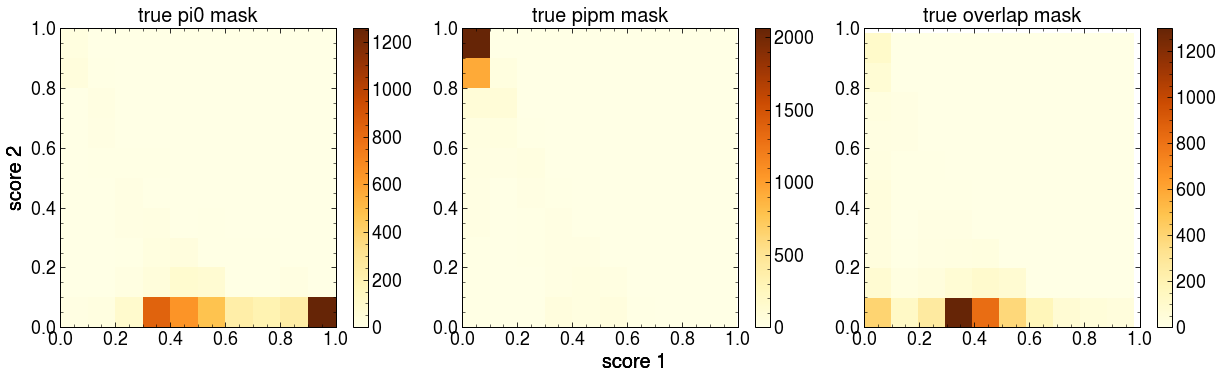

In [64]:
focus_Score2D(score1G2[0], score2G2[0], truths=[pi0masksG2[0], pipmmasksG2[0], lapmasksG2[0]])

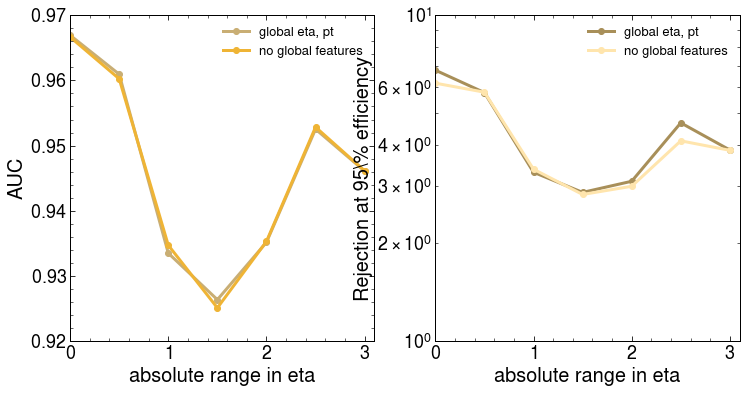

In [66]:
W.plots1(eta_ranges1, aucsL, aucsG2, reg95L, reg95G2, rangename='eta', globalpars='eta, pt', logx=False)
#here glob= glob 2, noglb = large